# **Z by HP Unlocked Challenge 3 - Signal Processing**

# **Deep Audio Classifier**

# Install necessary dependencies

In [1]:
!pip install tensorflow-io

# Import necessary libraries

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Exploration 

## Check how the data is, and figure out how to preprocess them

In [3]:
# Define paths to sample audio files
capuchin = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC16803-1.wav'
not_capuchin = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-at-night-13.wav'

In [4]:
# Read the contents of a .wav file
file_contents = tf.io.read_file(capuchin)
wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
wav, sample_rate

(<tf.Tensor: shape=(110250, 1), dtype=float32, numpy=
 array([[0.04174805],
        [0.03167725],
        [0.02420044],
        ...,
        [0.05834961],
        [0.05639648],
        [0.05609131]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=44100>)

In [5]:
# Check the shapes of the read contents
wav.shape, sample_rate.shape

(TensorShape([110250, 1]), TensorShape([]))

In [6]:
# Check the datatype of sample rate
print(sample_rate.dtype)

# Convert the datatype of sample rate to int64
sample_rate = tf.cast(sample_rate, tf.int64)
print(sample_rate.dtype)

<dtype: 'int32'>
<dtype: 'int64'>


In [7]:
# Squeeze and remove the trailing axis
wav = tf.squeeze(wav, axis=-1)
wav.shape

TensorShape([110250])

In [8]:
# Goes from 44100 Hz to 16000 Hz
wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
wav.shape, wav

(TensorShape([40000]),
 <tf.Tensor: shape=(40000,), dtype=float32, numpy=
 array([-3.3762734e-07,  9.5626194e-07, -1.1230819e-06, ...,
         1.3459712e-01,  1.5369581e-01,  1.1945116e-01], dtype=float32)>)

In [9]:
# Now that the data has been analyzed, we can create the Data Loader Function now.

# Data Loader Function

In [10]:
# Data Loading Function as in Tensorflow Documentation to process audio

# Function name - 16k refers to 16000Hz conversion and mono refers to single channel (refer function)

def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename) # Read the .wav file contents
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # Decode .wav to tensors by channels
    wav = tf.squeeze(wav, axis=-1) # Remove trailing axis
    sample_rate = tf.cast(sample_rate, dtype=tf.int64) # Cast int64 datatype to sample rate
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) # Goes from 44100 Hz to 16000 Hz
    return wav

# Visualize how the waveforms look

In [11]:
# Load and preprocess the audio files 
cap_wave = load_wav_16k_mono(capuchin)
not_cap_wave = load_wav_16k_mono(not_capuchin)

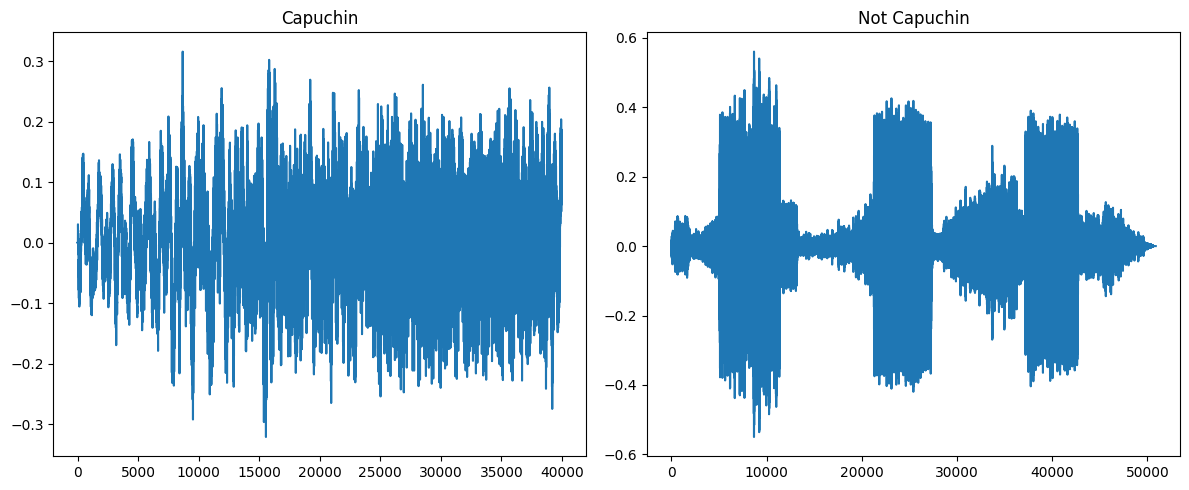

In [12]:
# Plot capuchin and non-capuchin audio waveforms separately
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title('Capuchin')
plt.plot(cap_wave)
plt.subplot(1, 2, 2)
plt.title('Not Capuchin')
plt.plot(not_cap_wave)
plt.tight_layout()

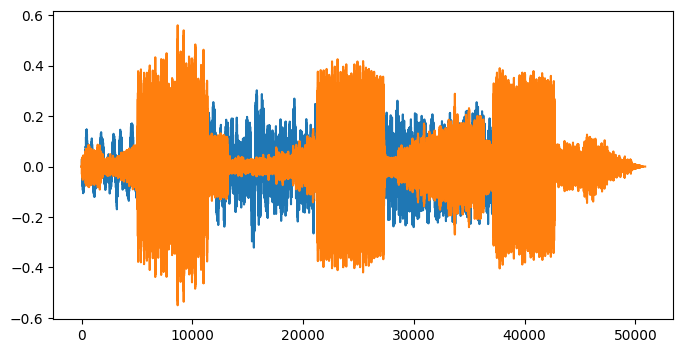

In [13]:
# Plot the waveforms together
plt.figure(figsize=(8,4))
plt.plot(cap_wave)
plt.plot(not_cap_wave)

# Create Tensorflow Dataset

In [14]:
# Define file paths
cap_path = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips'
non_cap_path = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips'

In [15]:
# Create datasets
cap = tf.data.Dataset.list_files(cap_path+'/*.wav')
non_cap = tf.data.Dataset.list_files(non_cap_path+'/*.wav')

In [16]:
# Check if the dataset is working fine
print(cap.as_numpy_iterator().__next__())
print(non_cap.as_numpy_iterator().__next__())

b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC520626-0.wav'
b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/magpie-call-sound-effect-0.wav'


In [17]:
# Check length of our datasets
len(cap), len(non_cap)

(217, 593)

# Add labels to the capuchin and non-capuchin datasets

In [18]:
# Let capuchin be denoted by 1 and non-capuchin be denoted by 0

# We need as many 1's as there are capuchins and as many 0's as there are non-capuchins
Ones = tf.ones(len(cap))
Zeros = tf.zeros(len(non_cap))

In [19]:
# Assign labels to the dataset using zip, so that each label is assigned inline
positives = tf.data.Dataset.zip((cap, tf.data.Dataset.from_tensor_slices(Ones)))
negatives = tf.data.Dataset.zip((non_cap, tf.data.Dataset.from_tensor_slices(Zeros)))

In [20]:
# Combine positives and negatives
data = positives.concatenate(negatives)
data.as_numpy_iterator().__next__(), len(data)

((b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC307385-1.wav',
  1.0),
 810)

# Determine average length of a Capuchin Bird call

In [21]:
# Calculate wave cycle length

lengths = []

for file in os.listdir(cap_path):
    tensor_wave = load_wav_16k_mono(os.path.join(cap_path, file))
    lengths.append(len(tensor_wave))

In [22]:
len(lengths), lengths

(217,
 [64000,
  48000,
  48000,
  56000,
  56000,
  64000,
  48000,
  56000,
  64000,
  56000,
  55999,
  72000,
  48000,
  56000,
  56000,
  40000,
  40000,
  56000,
  56000,
  64000,
  32000,
  56000,
  64000,
  40000,
  48000,
  64000,
  56000,
  40000,
  64000,
  48000,
  56000,
  64000,
  56000,
  56000,
  56000,
  48000,
  48000,
  56000,
  56000,
  72000,
  48000,
  48000,
  64000,
  39999,
  64000,
  56000,
  64000,
  56000,
  40000,
  64000,
  56000,
  56000,
  56000,
  48000,
  64000,
  48000,
  56000,
  72000,
  40000,
  48000,
  40000,
  48000,
  64000,
  48000,
  64000,
  56000,
  48000,
  64000,
  48000,
  64000,
  56000,
  56000,
  56000,
  56000,
  56000,
  48000,
  48000,
  40000,
  48000,
  64000,
  56000,
  40000,
  56000,
  32000,
  56000,
  48000,
  64000,
  64000,
  56000,
  56000,
  56000,
  48000,
  56000,
  56000,
  64000,
  56000,
  48000,
  48000,
  64000,
  40000,
  56000,
  48000,
  56000,
  56000,
  48000,
  56000,
  48000,
  72000,
  56000,
  56000,
  48

## Calculate mean, min and max

In [23]:
# Mean - (sum(lengths)/len(lengths))
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [24]:
# This means on an average, our capuchin bird calls are of length 54156/16000 ~ 3.3 seconds 

In [25]:
# Min
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [26]:
# Max
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# More Data exploration

## Play around with data to find out how it is, so that we can convert them to a spectrogram

In [27]:
# Reminder - sample capuchin is stored in capuchin variable
capuchin

'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC16803-1.wav'

In [28]:
wav = load_wav_16k_mono(capuchin)
wav = wav[:48000]
wav

<tf.Tensor: shape=(40000,), dtype=float32, numpy=
array([-3.3762734e-07,  9.5626194e-07, -1.1230819e-06, ...,
        1.3459712e-01,  1.5369581e-01,  1.1945116e-01], dtype=float32)>

In [29]:
tf.shape(wav)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([40000], dtype=int32)>

In [30]:
[48000] - tf.shape(wav)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([8000], dtype=int32)>

In [31]:
zp = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
zp

<tf.Tensor: shape=(8000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [32]:
wav = tf.concat([zp, wav], axis=0)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , ..., 0.13459712, 0.1536958 ,
       0.11945116], dtype=float32)>

In [33]:
s = tf.signal.stft(wav, frame_length=320, frame_step=32)
s

<tf.Tensor: shape=(1491, 257), dtype=complex64, numpy=
array([[ 0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j, ...,
         0.0000000e+00-0.00000000e+00j,  0.0000000e+00-0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j],
       [ 0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j, ...,
         0.0000000e+00-0.00000000e+00j,  0.0000000e+00-0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j],
       [ 0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j, ...,
         0.0000000e+00-0.00000000e+00j,  0.0000000e+00-0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j],
       ...,
       [-3.6098309e+00+0.00000000e+00j, -3.7309375e+00+5.16667032e+00j,
         5.9211483e+00+2.40808725e+00j, ...,
         1.3613701e-04+5.67436218e-05j,  1.5258789e-05-1.81198120e-05j,
        -6.9141388e-06-0.00000000e+00j],
       [ 1.67

In [34]:
s = tf.abs(s)
s

<tf.Tensor: shape=(1491, 257), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [3.6098309e+00, 6.3729410e+00, 6.3920956e+00, ..., 1.4748939e-04,
        2.3688777e-05, 6.9141388e-06],
       [1.6784097e+00, 6.2990026e+00, 6.7663050e+00, ..., 1.4335381e-04,
        3.7758495e-05, 4.4822693e-05],
       [7.1996279e+00, 8.4250135e+00, 7.3199263e+00, ..., 8.1265418e-05,
        4.4972880e-05, 1.6927719e-05]], dtype=float32)>

In [35]:
s = tf.expand_dims(s, axis=-1)
s

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       ...,

       [[3.6098309e+00],
        [6.3729410e+00],
        [6.3920956e+00],
        ...,
        [1.4748939e-04],
        [2.3688777e-05],
        [6.9141388e-06]],

       [[1.6784097e+00],
        [6.2990026e+00],
        [6.7663050e+00],
        ...,
        [1.4335381e-04],
        [3.7758495e-05],
        [4.4822693e-05]],

       [[7.1996279e+00],
        [8.4250135e+00],
        [7.3199263e+00],
        ...,
        [8.1265418

# Function to convert Audio to Spectrogram

In [36]:
# Function to convert Audio to Spectrogram
def convert_to_spectrogram(filepath, label):
    '''We pass in filepath, label into the function so that we can map this to our previously created Dataset,
       which contains data in the form (filepath, label)'''
    
    wav = load_wav_16k_mono(filepath)
    wav = wav[:48000] # A majority amount of data to preprocess from each audio file
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], axis=0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # For the channels dimension that CNNs need
    return spectrogram, label

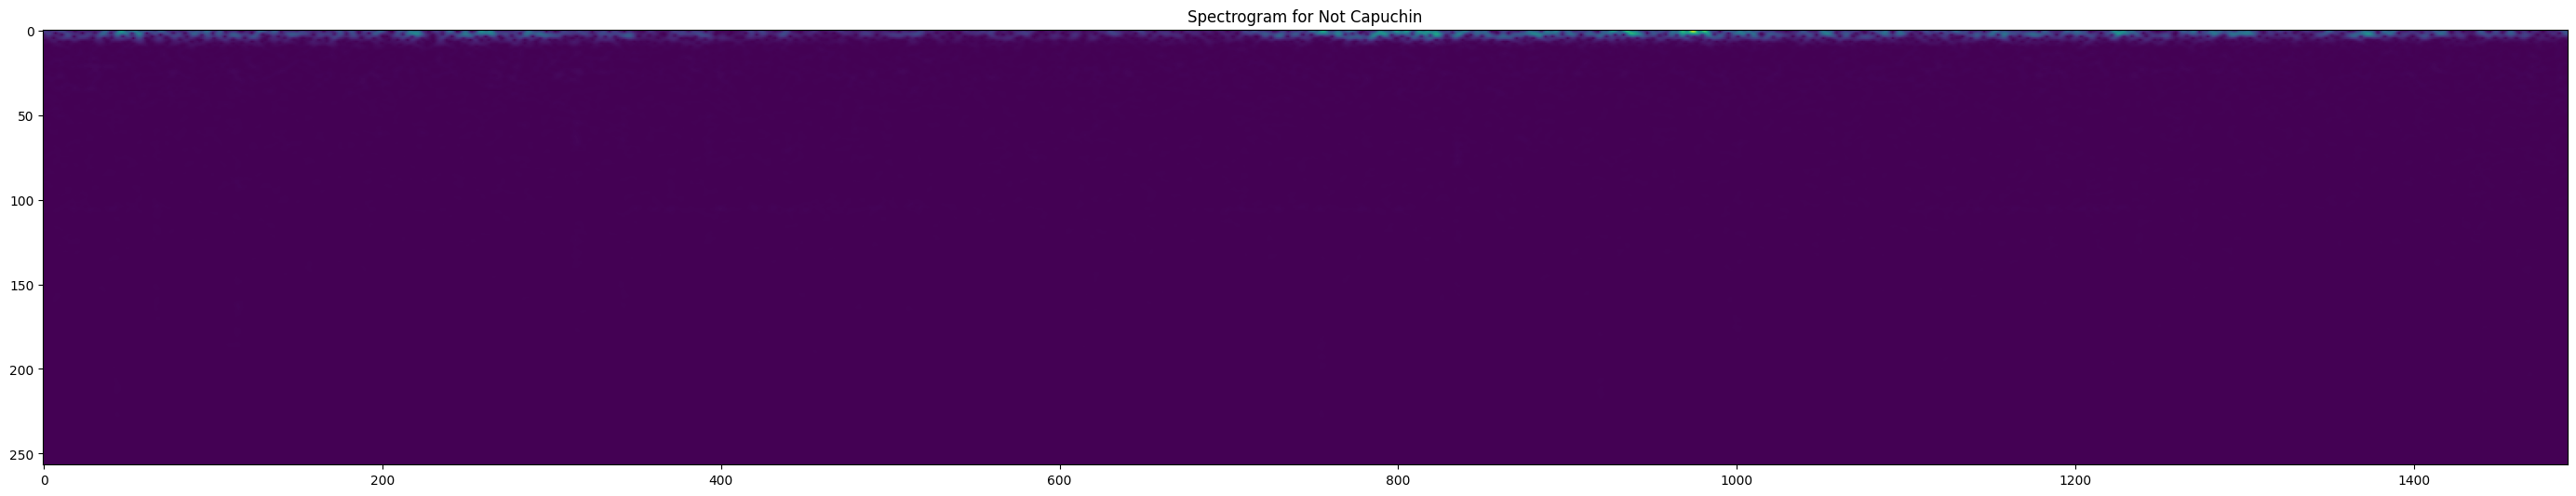

In [37]:
# Get a sample spectrogram and visualize it
fp, lbl = data.shuffle(10000).as_numpy_iterator().__next__()
spc, lbl = convert_to_spectrogram(fp, lbl)
plt.figure(figsize=(35, 30))
plt.imshow(tf.transpose(spc)[0])
plt.title(f"Spectrogram for {'Capuchin' if lbl==1 else 'Not Capuchin'}")
plt.show()

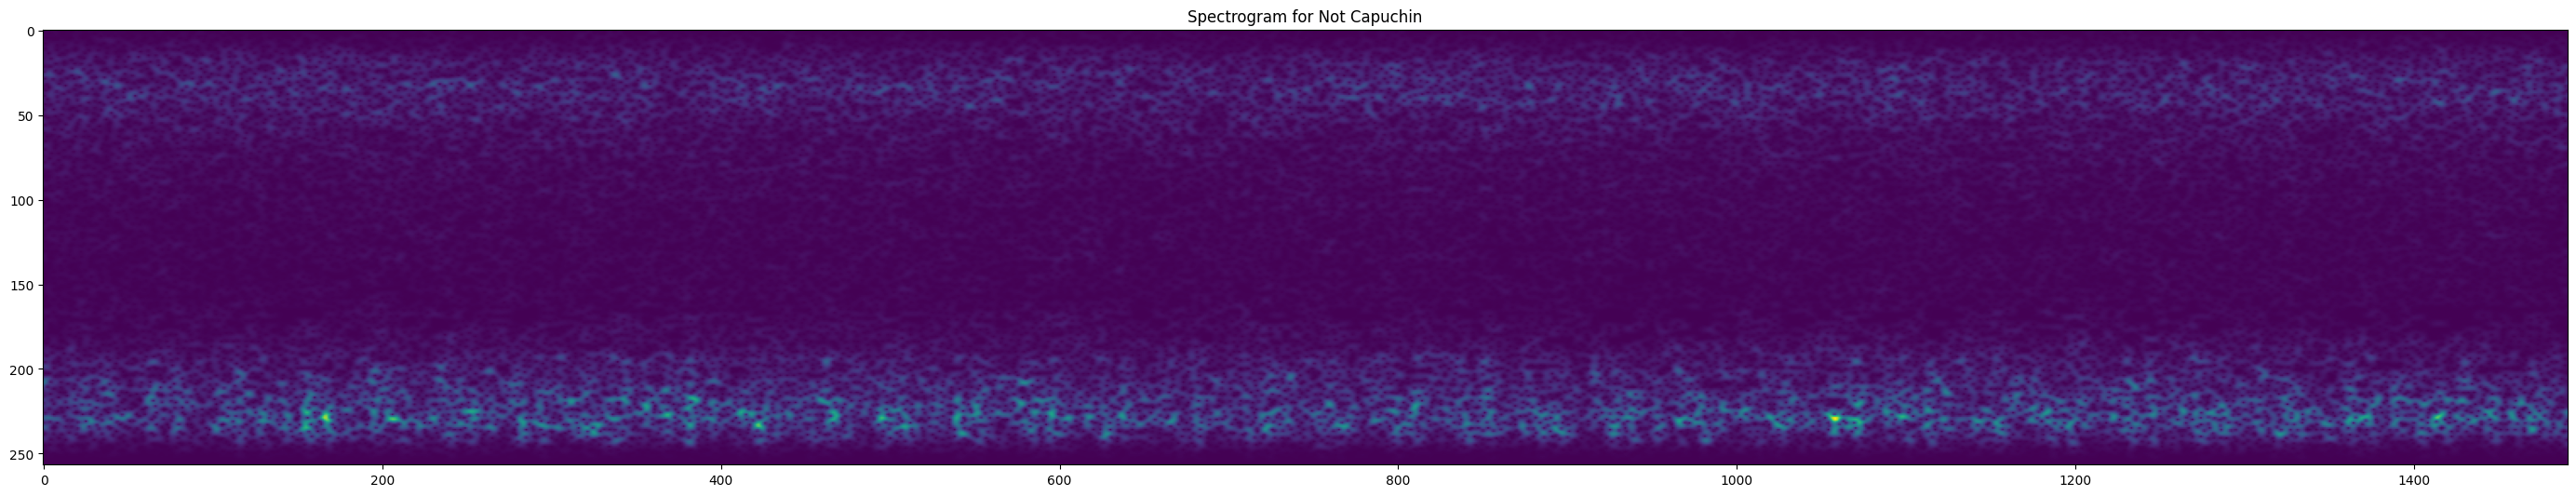

In [38]:
# Get a sample spectrogram and visualize it
fp, lbl = data.shuffle(10000).as_numpy_iterator().__next__()
spc, lbl = convert_to_spectrogram(fp, lbl)
plt.figure(figsize=(35, 30))
plt.imshow(tf.transpose(spc)[0])
plt.title(f"Spectrogram for {'Capuchin' if lbl==1 else 'Not Capuchin'}")
plt.show()

# Create Data pipeline, and train-test splits

In [39]:
# Create Data Pipeline
data = data.map(convert_to_spectrogram)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [40]:
# Check length of data
len(data)

51

In [41]:
# Split into train and test partitions
train = data.take(36)
test = data.skip(36).take(15)

In [42]:
# Test sample batch
sample, label = train.as_numpy_iterator().__next__()
sample.shape, label

((16, 1491, 257, 1),
 array([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       dtype=float32))

# Build Deep Learning Model

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L

# Build a Sequential Model
model = Sequential(name="model")
model.add(L.Conv2D(16, 3, activation="relu", input_shape=(1491, 257, 1)))
model.add(L.MaxPool2D((2,2)))
model.add(L.BatchNormalization())
model.add(L.Conv2D(32, 3, activation="relu"))
model.add(L.MaxPool2D((2,2)))
model.add(L.BatchNormalization())
model.add(L.Flatten())
model.add(L.Dropout(0.15))
model.add(L.Dense(128, activation="relu"))
model.add(L.Dense(1, activation="sigmoid"))

In [63]:
# Compile the model
model.compile(loss="binary_crossentropy",
             optimizer='Adam',
             metrics=["accuracy",
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.Precision()])

# View the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 744, 127, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 32)      0         
 2D)                                                             
                                                             

In [64]:
# Train the model
history = model.fit(train, epochs=10, validation_data=test)

Epoch 1/10
36/36 [==============================] - 8s 115ms/step - loss: 2.6057 - accuracy: 0.9792 - recall_1: 0.9688 - precision_1: 0.9568 - val_loss: 16.5495 - val_accuracy: 0.8590 - val_recall_1: 0.5000 - val_precision_1: 1.0000
Epoch 2/10
36/36 [==============================] - 3s 86ms/step - loss: 0.9956 - accuracy: 0.9861 - recall_1: 0.9804 - precision_1: 0.9677 - val_loss: 62.5682 - val_accuracy: 0.8419 - val_recall_1: 0.4127 - val_precision_1: 1.0000
Epoch 3/10
36/36 [==============================] - 3s 81ms/step - loss: 3.6483 - accuracy: 0.9722 - recall_1: 0.9404 - precision_1: 0.9530 - val_loss: 12.3957 - val_accuracy: 0.9231 - val_recall_1: 0.7885 - val_precision_1: 0.8542
Epoch 4/10
36/36 [==============================] - 3s 79ms/step - loss: 0.8566 - accuracy: 0.9878 - recall_1: 0.9801 - precision_1: 0.9737 - val_loss: 12.7942 - val_accuracy: 0.9402 - val_recall_1: 0.8095 - val_precision_1: 0.9623
Epoch 5/10
36/36 [==============================] - 3s 82ms/step - loss

In [46]:
model.save('/kaggle/working/Deep_Audio_Classifier.h5')

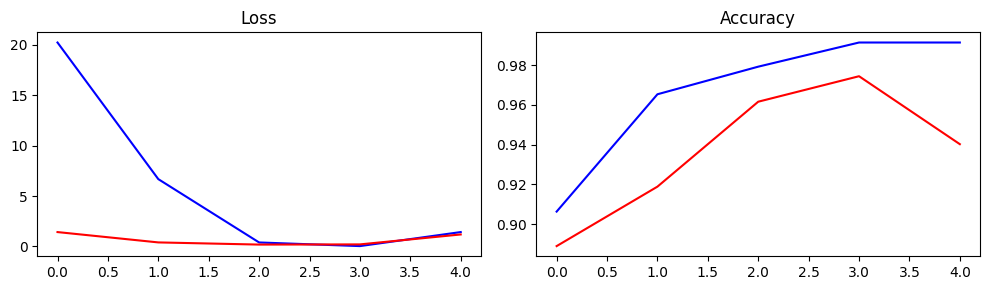

In [47]:
# Plot the loss accuracy curves

plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')

plt.tight_layout()

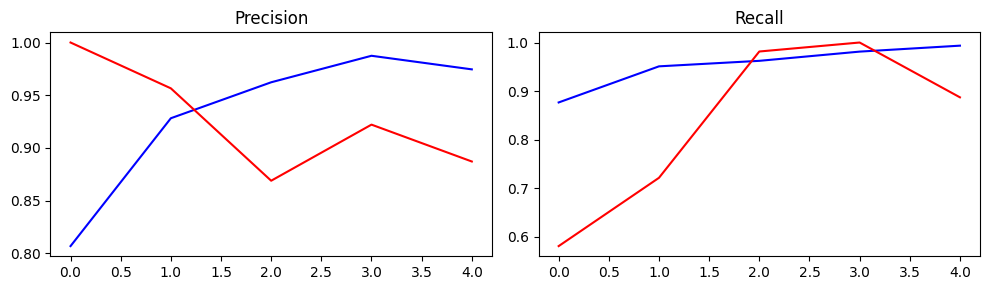

In [48]:
# Plot Precision and Recall Curves

plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'r')

plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'r')

plt.tight_layout()

# Make a prediction on one Batch of Test Data

In [49]:
# Get one batch of test data
X_test, y_test = test.as_numpy_iterator().__next__()

In [50]:
# Check the shape of the X_test
X_test.shape

(16, 1491, 257, 1)

In [51]:
# Make predictions
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 141ms/step


In [52]:
# Convert the probabilities to classes
y_pred = [1 if prediction>0.99 else 0 for prediction in y_pred] # Use high confidence
y_pred

[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [53]:
# Check number of actual capuchin calls in our predictions and original test data
tf.math.reduce_sum(y_test), tf.math.reduce_sum(y_pred)

(<tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>)

In [54]:
# Check the classes of the calls in our predictions and original test data
y_pred, y_test.astype(int)

([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [55]:
# Comment about the model's performance

# Working on Forest Audio to identify Capuchin calls

In [56]:
# Build Forest parsing function - load .mp3 files
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)           # Load the audio 
    tensor = res.to_tensor()                           # Convert the tensor
    tensor = tf.math.reduce_sum(tensor, axis=1)/2      # Combine the channels
    sample_rate = res.rate                             # Extract sample rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64) # Cast int64 datatype
    wav = tfio.audio.resample(                         # Resample to 16KHz
        tensor, rate_in=sample_rate, rate_out=16000
    )
    
    return wav

## **Little Data Exploration to figure out how to work with the Forest Recordings**

#### *Note - Working on only one audio and making predictions on it. Once it seems to be working fine, we move on to working and predicting on all the audio files.*

In [57]:
# Check working with sample Forest recording
mp3 = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3'

# Convert to wav
wav = load_mp3_16k_mono(mp3)

In [58]:
# Slice the entire Forest audio into time slices of the same size as our model was trained on
audio_slices = tf.keras.utils.timeseries_dataset_from_array(
                wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1
            )

In [59]:
samples, index = audio_slices.as_numpy_iterator().__next__() # Fetch a batch 
len(audio_slices), samples.shape

(60, (1, 48000))

In [60]:
''' Here, what we're doing is taking the big audio clip which is in .mp3 format,
    process it and return processed .wav file/ Then we take the .wav file and slice it into windows of 
    48000Hz, convert each window to spectrograms each, and make predictions on each spectrogram, and 
    return the aggregated output.'''

" Here, what we're doing is taking the big audio clip which is in .mp3 format,\n    process it and return processed .wav file/ Then we take the .wav file and slice it into windows of \n    48000Hz, convert each window to spectrograms each, and make predictions on each spectrogram, and \n    return the aggregated output."

# Convert Forest clips to Spectrogram and convert them to windows

In [61]:
def preprocess_mp3(sample, index):
    sample = sample[0] # Take the element
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], axis=0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # For the channels dimension that CNNs need
    return spectrogram, label

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(
                wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1
            )
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

# Make Predictions and group Consecutive Detections

##### *We need to group consecutive detections, as they account to only one call per detection, even if it means the detection length was long*

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if pred > 0.99 else 0 for pred in yhat] # Use high confidence
yhat.shape, yhat

In [ ]:
# Group calls
from itertools import groupby

yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls

# Work and predict on all the Audio Files

In [ ]:
results = {}
forest_recordings_path = ;'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings'

for file in os.listdir(forest_recordings_path):
    # Get File Path
    FILEPATH = os.path.join(forest_recordings_path, file)
    
    # Preprocess .mp3 files
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(
                wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1
            )
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    # Make predictions and group consecutive calls
    
    yhat = model.predict(audio_slices)
    yhat = [1 if pred > 0.99 else 0 for pred in yhat] # Use high confidence
    yhat = [key for key, group in groupby(yhat)]
    calls = tf.math.reduce_sum(yhat).numpy()
    
    results[file] = calls

# Export Results as .csv file

In [ ]:
import csv

with open ("capuchinbird_calls_results.csv", "w", newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['Recording', 'Capuchin_Calls'])
    for key, value in results:
        writer.writerow([key, value])